# Extraction and EDA

This notebook extracts the data and performs analysis to test for feature availability.

In [1]:
import os
import glob
from typing import Dict, Union, List
import logging
from functools import reduce
from copy import deepcopy
import pandas as pd
import numpy as np
import re, string
from pandas.core.tools.datetimes import _guess_datetime_format_for_array

# set logger level
logging.basicConfig(level=logging.DEBUG)

def data_into_dict(
        filepath: Union[str, List], 
) -> Dict[str, pd.DataFrame]:   
    """Read data from paths into dictionary values
    This is an example of Google style.

    Args:
        filepath (Union[str, List]) : string literal of list of strings pointing to files for io
    Returns:
        file_d: dictionary of files as dataframes, with key as filename abbreviation
    """
    logging.info(f"Filepaths: {filepath}")
    # create file dictionary
    file_d = dict()
    for f in filepath:
        # get abbreviation for key
        fname_abbr =  os.path.split(f)[1].split(".")[0]
        logging.info(f"Reading {f} into key {fname_abbr}")
        # read dataframe into value
        file_d[fname_abbr] = pd.read_csv(f)
    return file_d


# read in data from dir
data_path = "../data/data/"
# group filenames by prefix
a_files = data_into_dict(glob.glob(os.path.join(data_path, "a__*")))
b_files = data_into_dict(glob.glob(os.path.join(data_path, "b__*")))

# consolidate dataframe groups into merged structure 
def merge_all_frames(
    frames: Dict, 
    on: str, 
    how: str, 
    rename_exclusions: List=[]
) -> pd.DataFrame:
    """Merge all frames in list into single dataframe 

    Args:
        frames (Dict) : dict of dfs with frame values to merge into single frame
        on (str) : column to merge on 
        how (str) : merge type
        rename (List) : list of columns to not rename
    Returns:
        frame_merged (pd.DataFrame): merged dataframe
    """
    frames = deepcopy(frames)
    # append df key names to columns to resolve conflicts in col names
    for frame in frames.items(): 
        frames[frame[0]] = frame[1].rename({col:f"{col}_{frame[0]}" \
            for col in frame[1] if (col!=on) and (col not in rename_exclusions)}, axis=1)

    # merge frames and set key value as conflicting column suffixes
    logging.info(f"Merging values of {frames.keys()}")
    frame_merged = reduce(
                lambda  left,right: pd.merge(left,right,on=[on],how=how), frames.values()
            )
        
    return frame_merged

a_frame = merge_all_frames(a_files, on="geo_id", how='outer', rename_exclusions=['vendor_id'])
b_frame = merge_all_frames(b_files, on="b_entity_id", how='outer')

a_frame = a_frame.set_index("vendor_id").reset_index()
b_frame = b_frame.set_index("b_entity_id").reset_index()

INFO:root:Filepaths: ['../data/data/a__geo.csv', '../data/data/a__company.csv']
INFO:root:Reading ../data/data/a__geo.csv into key a__geo
INFO:root:Reading ../data/data/a__company.csv into key a__company
INFO:root:Filepaths: ['../data/data/b__company.csv', '../data/data/b__hierarchy.csv', '../data/data/b__address.csv']
INFO:root:Reading ../data/data/b__company.csv into key b__company
INFO:root:Reading ../data/data/b__hierarchy.csv into key b__hierarchy
INFO:root:Reading ../data/data/b__address.csv into key b__address
/var/folders/vn/k48mm0r10wn2dfq08pnrlbtc0000gn/T/ipykernel_49663/3202556339.py:34: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  file_d[fname_abbr] = pd.read_csv(f)
INFO:root:Merging values of dict_keys(['a__geo', 'a__company'])
INFO:root:Merging values of dict_keys(['b__company', 'b__hierarchy', 'b__address'])


In [2]:
def type_compression(
    frame: pd.DataFrame, 
    column_exclusions: List=[],
    numeric_proportion_threshold: float=0.5
) -> pd.DataFrame:
    """Compress types of values into a standard

    Args:
        frame (pd.DataFrame) : data frame to compress types
        column_exclusions (List) : columns to exclude from compression
        numeric_proportion_threshold (float) : proportion of values in mixed type column
            that must pass numeric validation in order to convert that column to either float or int type
    Returns: 
        frame_comp (pd.DataFrame) : compressed type data
    """
    # get column types
    col_types = frame.dtypes.to_dict()
    # replace na value with string literal
    frame = frame.fillna("null")
    # set heuristic inline function for testing non-null string values
    non_null = lambda x: ('null' not in x.lower().replace(" ", "")) \
        and ('nan' not in x.lower().replace(" ", ""))\
        and ('notdefined' not in x.lower().replace(" ", ""))\
        and ('na' not in x.lower().replace(" ", ""))
    # convert object types to string values
    for i, data in enumerate(col_types.items()):
        # column is first index of data item
        col = data[0]
        logging.info(f"Pointing to column in position {i}")
        # log column position
        if col not in column_exclusions:
            logging.info(f"Working compression on column {col}")
            frame[col] = frame[col].astype(str)
            # get all values in series that are not null
            non_null_index = frame[col].apply(non_null)
            non_null_s = frame[col][non_null_index]
            # create inline function for testing if data is numeric, only stripping dashes from left 
            isnum = lambda x: (x.lstrip("-").replace(".", "").isnumeric()) and (x.count(".")<=1)
            isnum_s = non_null_s.apply(isnum)
            isnum_sum, isnum_true = isnum_s.value_counts().sum(), isnum_s.value_counts().get(True)
            # get proportion of numeric strings in non-null series
            # get proportion is numeric values are present
            if isnum_true:
                isnum_prop = float(isnum_true)/float(isnum_sum)
            else: 
                isnum_prop = 0
            logging.info(f"Numeric proportion for {col}: {isnum_prop}")
            # strip whitespace
            frame[col] = frame[col].str.strip()
            # check proprtion and convert based upon value
            if isnum_prop >= numeric_proportion_threshold:
                col_numeric = frame[col].apply(isnum)
                # check for int values among all numeric values
                int_check = frame[col][col_numeric]\
                    .apply(lambda x: set(x.split(".")[-1]).issubset("0") or x.isdigit())
                if int_check.all():
                    # set null type
                    frame.loc[~col_numeric,col] = np.nan
                    # set type as int, with float conversion first
                    # to offset np.nan type data
                    frame[col] = frame[col].astype("float")
                    frame[col] = frame[col].astype("Int64")
                    logging.info(f"Converted column {col} into Int64 type.")
                else: 
                    # set null type
                    frame.loc[~col_numeric,col] = np.nan
                    # set type as float if non-int numeric values exist
                    frame[col] = frame[col].astype("float")
                    logging.info(f"Converted column {col} into float type.")
            # if non null values are not primarily numeric, then convert to lowercase
            # and remove non-alphanumeric chars
            else:
                # convert all to lowercase
                frame[col] = frame[col].apply(str.lower)
                # create regex pattern for keeping only alphanumeric characters
                frame.loc[non_null_index, col] = frame[col][non_null_index]\
                    .apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', "", x))
                # create regex pattern for removing redundant whitespace
                frame.loc[non_null_index, col] = frame[col][non_null_index]\
                    .apply(lambda x: re.sub(" +", " ", x))
                # convert all null values to nan
                frame.loc[~non_null_index,col] = np.nan
                logging.info(f"Converted column {col} into string type.")
        else:
            logging.info(f"Column {col} excluded.") 


    return frame



a_comp = type_compression(frame=a_frame, column_exclusions=['vendor_id'])
b_comp = type_compression(frame=b_frame, column_exclusions=['b_entity_id'])

INFO:root:Pointing to column in position 0
INFO:root:Column vendor_id excluded.
INFO:root:Pointing to column in position 1
INFO:root:Working compression on column geo_id
INFO:root:Numeric proportion for geo_id: 1.0
INFO:root:Converted column geo_id into Int64 type.
INFO:root:Pointing to column in position 2
INFO:root:Working compression on column zipcode_a__geo
INFO:root:Numeric proportion for zipcode_a__geo: 0.9727074016884913
INFO:root:Converted column zipcode_a__geo into Int64 type.
INFO:root:Pointing to column in position 3
INFO:root:Working compression on column is_primary_a__geo
INFO:root:Numeric proportion for is_primary_a__geo: 0
INFO:root:Converted column is_primary_a__geo into string type.
INFO:root:Pointing to column in position 4
INFO:root:Working compression on column latitude_a__geo
INFO:root:Numeric proportion for latitude_a__geo: 0.9878210806023029
INFO:root:Converted column latitude_a__geo into float type.
INFO:root:Pointing to column in position 5
INFO:root:Working co

## Clustering and Analysis

This section of the notebook analyzes the data in an unsupervised fashion. The datasets are tested for similarity by clustering around an arbitrary number of centroids. 

DEBUG:matplotlib:matplotlib data path: /Users/cullenpaulisick/opt/anaconda3/envs/govini/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/cullenpaulisick/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/cullenpaulisick/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/cullenpaulisick/.matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/cullenpaulisick/opt/anaconda3/envs/govini/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='norma

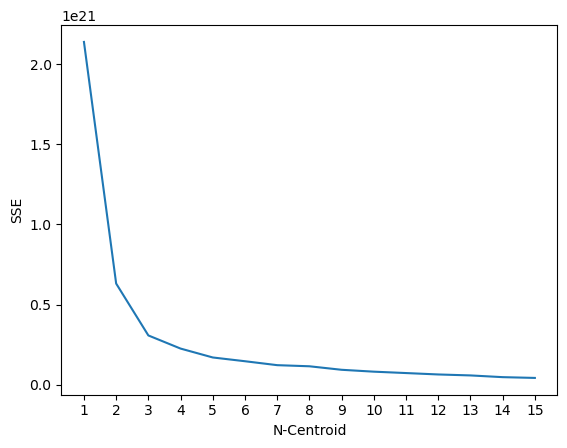

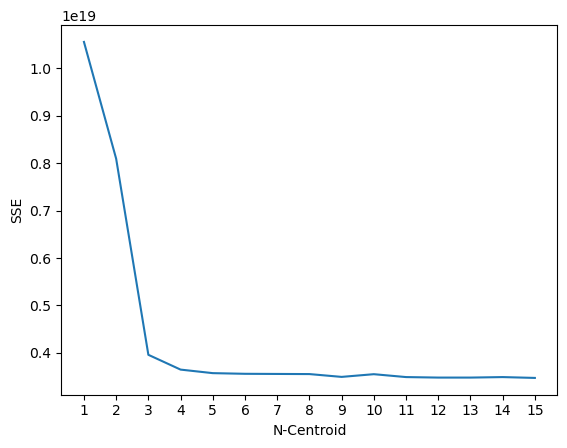

In [3]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def centroid_analysis(
    frame: pd.DataFrame,
    index: str, 
    kmeans_parameters: Dict[str, Union[int, str]], 
    kmeans_iter: int, 
    visualize: bool=False
) -> int:
    """Find optimal number of centroids through recommended evaluation metric

    Function that find the optimal number of centroids in a dataset. Used to evaluate unlabeled datasets for 
    similarity metrics. 

    Args:   
        frame (pd.DataFrame) : frame used to find centroids
        index (str) : primary index of frame
        kmeans_parameters (Dict[str, Union[int, str]]) : kmeans values used as parameters
        kmeans_iter (int) : number of iterations to run on kmeans cluster
        eval_method (int) : method of evaluation 
        visualize (bool) : visualization preference for elbow analysis
    Returns: 
        n_centroids (int) : number of centroids that are considered optimal
    """

    comp_num = frame[[col for col, datatype in frame.dtypes.to_dict().items() if (datatype != np.dtype('O'))or (col==index)]]
    # check primary index for all unique values
    if comp_num.index.value_counts().max()==1: 
        comp_dropna = comp_num.set_index(index).dropna()
        col_map = comp_dropna.columns.to_numpy()
        comp_vals = comp_dropna.values
    # if non-unique primary index, consolidate based upon append-only insert on schema
    else:
        # get last index for each group
        max_index_per_entity = comp_num.reset_index().groupby(index)['index'].max()
        comp_dropna = comp_num.iloc[list(max_index_per_entity.values)].set_index(index).dropna()
        col_map = comp_dropna.columns.to_numpy()
        comp_vals = comp_dropna.values
    # start inertia compilation
    inertia_values = list()
    for i in range(1,kmeans_iter):
        km = KMeans(n_clusters=i, **kmeans_parameters)
        # fit data to numpy data
        km.fit(comp_vals)
        inertia_values.append(km.inertia_)
    if visualize:
        plt.xticks(range(1, kmeans_iter))
        plt.plot(range(1, kmeans_iter), inertia_values)
        plt.xlabel("N-Centroid")
        plt.ylabel("SSE")
        plt.show()
    # return elbow from method
    knee = KneeLocator(
        range(1, kmeans_iter), 
        inertia_values, 
        curve="convex",
        direction="decreasing"
    )
    elbow = knee.elbow
    return elbow, comp_vals, col_map

a_elbow, a_comp_vals, a_col_map = centroid_analysis(
    frame=a_comp, 
    index='vendor_id', 
    kmeans_parameters={
        "init": "random",
        "n_init": 10,
        "max_iter": 500,
        "random_state": 0,
    }, 
    kmeans_iter=16, 
    visualize=True
)
b_elbow, b_comp_vals, b_col_map = centroid_analysis(
    frame=b_comp, 
    index='b_entity_id', 
    kmeans_parameters={
        "init": "random",
        "n_init": 10,
        "max_iter": 500,
        "random_state": 0,
    }, 
    kmeans_iter=16,
    visualize=True
)

In [4]:
def get_balance_distribution(
    features: np.array
) -> List: 
    """Get the balance distribution for each feature in numpy array
    
    Args:
        features (np.array) : feature set
    Returns: 
        balance_distributions (List) : list of balance distributions for each column in array
    """
    balance_distributions = []
    for i in range(features.shape[1]):
        feature = features[:, i]
        # get unique values for feature
        unique, counts = np.unique(feature, return_counts=True)
        # get count for each unique value in array
        counts = np.asarray((unique, counts)).T[:, 1]
        # get count distribution
        count_distribution = counts/sum(counts)
        balance_distributions.append(count_distribution)
    return balance_distributions
    

In [5]:
a_bd = get_balance_distribution(a_comp_vals)
b_bd = get_balance_distribution(b_comp_vals)

In [6]:
from scipy.stats import ks_2samp

d_stat = np.zeros(shape=(len(a_bd), len(b_bd)))
for i, a_dist in enumerate(a_bd):
    for j, b_dist in enumerate(b_bd):
        d_stat[i][j] = ks_2samp(a_dist,b_dist).statistic

In [9]:
import plotly.express as px

stat_df = pd.DataFrame(data = -d_stat, index=a_col_map, columns=b_col_map)
fig = px.imshow(stat_df)
fig.show()

In [8]:
stat_df.shape

(23, 15)